In [25]:
#%%% JSON content script
import pandas as pd
import numpy as np
import json
from sqlalchemy import create_engine

connection_string = 'mssql+pyodbc:///?odbc_connect=' \
                    'Driver%3D%7BODBC+Driver+17+for+SQL+Server%7D%3B' \
                    'Server%3Dmaxreportsrvr.database.windows.net%3B' \
                    'Database%3Dmax_report_db%3B' \
                    'UID%3Dreportadmin%3B' \
                    'PWD%3D#DAff!%nz8r7'\

engine = create_engine(connection_string)

# Create the SQL-query to retrieve the "EmailID," "To," and "Content" columns from the "Emails" table
sql = """SELECT 
            L.MXRITEMNAME,
            L.SALESORDERNUMBER,
            CAST(H.ORDERCREATIONDATETIME AS DATE) as ORDERCREATIONDATE,
            SUM(CASE WHEN L.ORDEREDSALESQUANTITY > 0 THEN L.ORDEREDSALESQUANTITY ELSE 0 END) AS TotalSalesQuantity
        FROM 
            [dbo].[SalesOrderLineV2Staging] L
        JOIN 
            [dbo].[SalesOrderHeaderV2Staging] H ON L.SALESORDERNUMBER = H.SALESORDERNUMBER
        WHERE 
            L.DATAAREAID = 'MNHQ'
            AND (L.MXRITEMNAME = 'Tegel' OR L.MXRITEMNAME = 'Vloerverwarming')
        GROUP BY 
            L.MXRITEMNAME, L.SALESORDERNUMBER, CAST(H.ORDERCREATIONDATETIME AS DATE)
            ORDER BY L.SALESORDERNUMBER;

         """

# Get the email data as a Pandas DataFrame
data = pd.read_sql(sql, engine)

# Close the database connection
engine.dispose()


In [37]:
duplicated_order_numbers = data.pivot_table(index=['SALESORDERNUMBER'], aggfunc='size')[lambda x: x >= 2].index
data = data[data['SALESORDERNUMBER'].isin(duplicated_order_numbers)]
data.sort_values(by=['MXRITEMNAME'], inplace=True)

# Initialize the new columns
ex_data = pd.DataFrame(columns=['SALESORDERNUMBER', 'ORDERCREATIONDATE', 'Tegel', 'Vloerverwarming'])

# Step 2: Fill in the counts
for order_number in duplicated_order_numbers:
    order_data = data[data['SALESORDERNUMBER'] == order_number]
    if order_data['MXRITEMNAME'].iloc[0] == order_data['MXRITEMNAME'].iloc[1]:
        tot_count = order_data['TotalSalesQuantity'].iloc[0] + order_data['TotalSalesQuantity'].iloc[1]
        ex_data.loc[len(ex_data.index)] = [order_number, order_data['ORDERCREATIONDATE'].iloc[0], tot_count, 0]
    else:
        ex_data.loc[len(ex_data.index)] = [order_number, order_data['ORDERCREATIONDATE'].iloc[0], order_data['TotalSalesQuantity'].iloc[0], order_data['TotalSalesQuantity'].iloc[1]]

ex_data.drop(ex_data[ex_data['Vloerverwarming'] == 0].index, inplace=True)

In [38]:
ex_data

,SALESORDERNUMBER,ORDERCREATIONDATE,Tegel,Vloerverwarming
61,MNHQSO0400545,2023-09-11,42.0,2.0
62,MNHQSO0401376,2023-09-13,60.0,2.0
63,MNHQSO0401578,2023-09-14,26.0,2.0
64,MNHQSO0401712,2023-09-14,42.0,2.0
65,MNHQSO0402258,2023-09-16,66.0,2.0
...,...,...,...,...
211,MNHQSO0451034,2024-01-15,48.0,2.0
212,MNHQSO0451176,2024-01-16,56.0,2.0
213,MNHQSO0452957,2024-01-20,50.0,2.0
214,MNHQSO0453481,2024-01-21,74.0,2.0


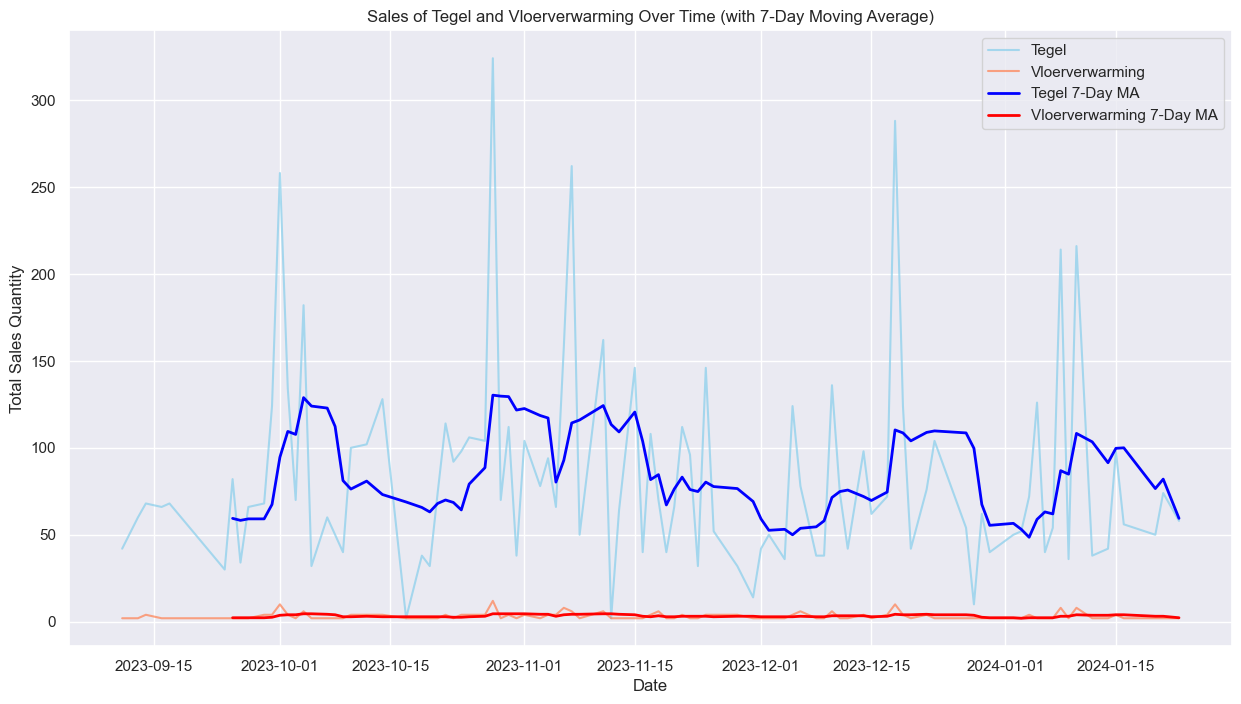

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Seaborn settings
sns.set(style="darkgrid")

# Ensure ORDERCREATIONDATE is a datetime type
ex_data['ORDERCREATIONDATE'] = pd.to_datetime(ex_data['ORDERCREATIONDATE'])

# Group by ORDERCREATIONDATE and sum the quantities for each product
grouped_data = ex_data.groupby('ORDERCREATIONDATE').sum()

# Calculate 7-day moving average for smoother trend lines
grouped_data['Tegel_MA'] = grouped_data['Tegel'].rolling(window=7).mean()
grouped_data['Vloerverwarming_MA'] = grouped_data['Vloerverwarming'].rolling(window=7).mean()

# Plotting
plt.figure(figsize=(15, 8))
plt.plot(grouped_data.index, grouped_data['Tegel'], label='Tegel', color='skyblue', alpha=0.7)
plt.plot(grouped_data.index, grouped_data['Vloerverwarming'], label='Vloerverwarming', color='coral', alpha=0.7)
plt.plot(grouped_data.index, grouped_data['Tegel_MA'], label='Tegel 7-Day MA', color='blue', linewidth=2)
plt.plot(grouped_data.index, grouped_data['Vloerverwarming_MA'], label='Vloerverwarming 7-Day MA', color='red', linewidth=2)

plt.title('Sales of Tegel and Vloerverwarming Over Time (with 7-Day Moving Average)')
plt.xlabel('Date')
plt.ylabel('Total Sales Quantity')
plt.legend()
plt.show()


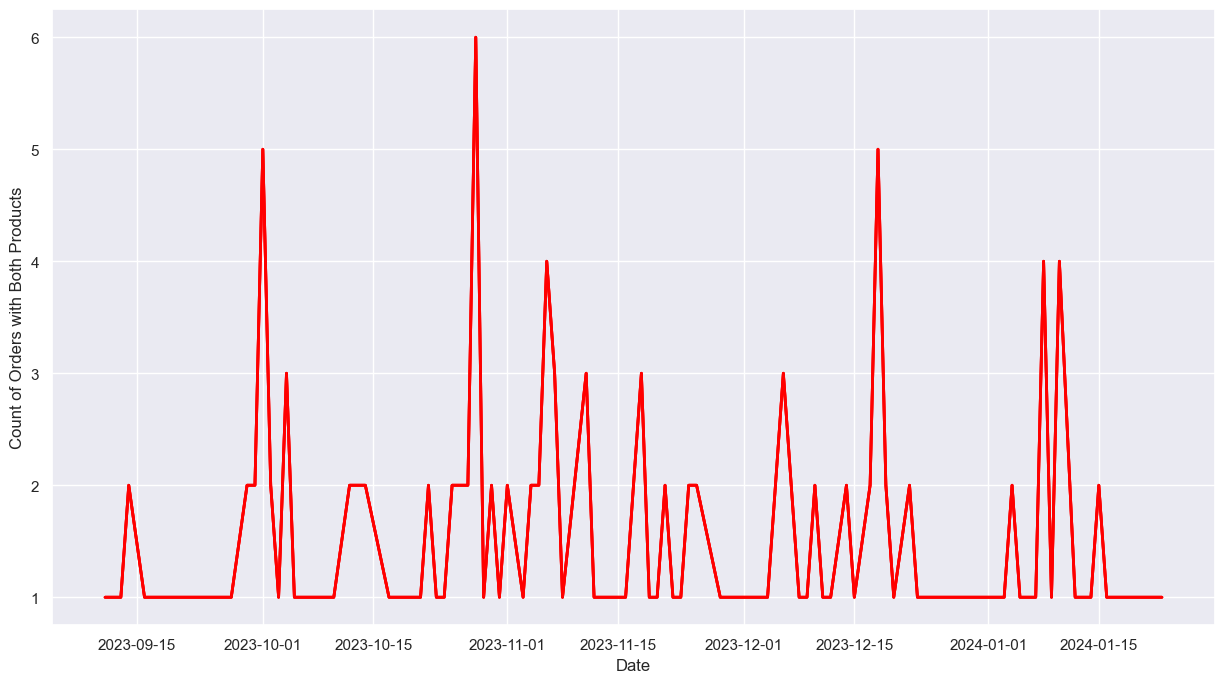

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Seaborn settings
sns.set(style="darkgrid")

# Ensure ORDERCREATIONDATE is a datetime type
ex_data['ORDERCREATIONDATE'] = pd.to_datetime(ex_data['ORDERCREATIONDATE'])

# Group by ORDERCREATIONDATE and sum the quantities for each product
grouped_data = ex_data.groupby('ORDERCREATIONDATE').sum()
count = ex_data.groupby('ORDERCREATIONDATE').count()


plt.figure(figsize=(15, 8))
plt.plot(grouped_data.index, count, color='red', linewidth=2)

plt.title('')
plt.xlabel('Date')
plt.ylabel('Count of Orders with Both Products')
plt.show()


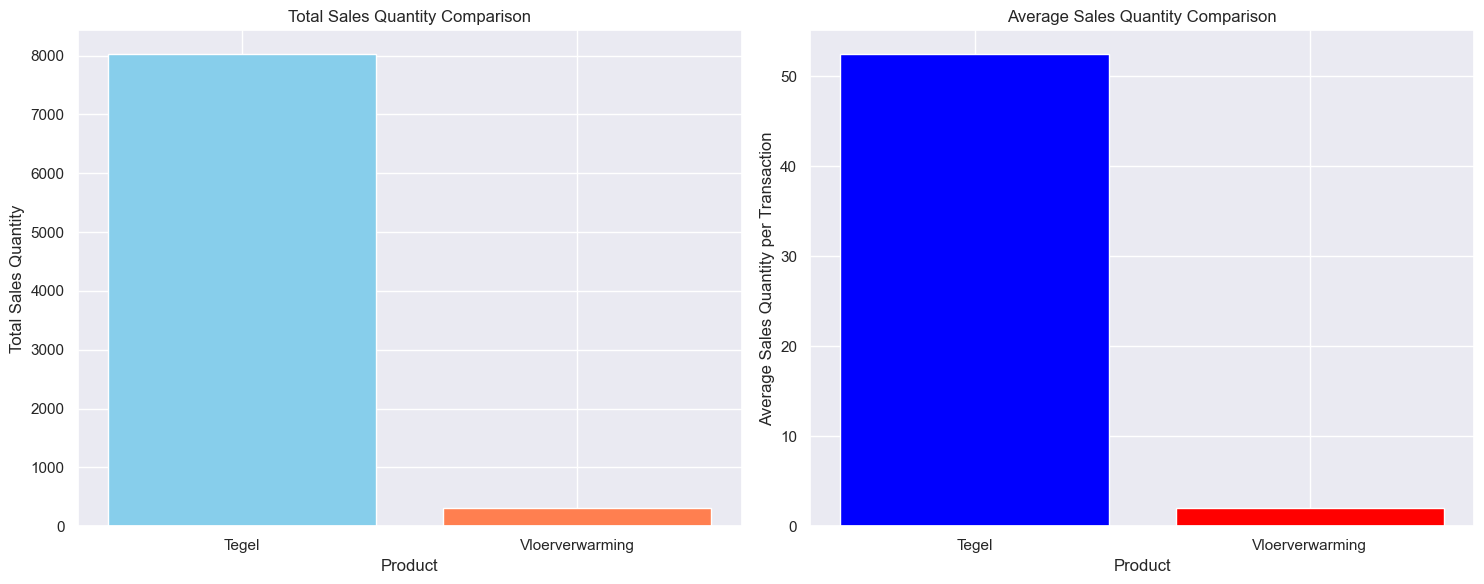

In [53]:
# Calculations
total_tegel = ex_data['Tegel'].sum()
total_vloerverwarming = ex_data['Vloerverwarming'].sum()
avg_tegel = ex_data['Tegel'].mean()
avg_vloerverwarming = ex_data['Vloerverwarming'].mean()

# Plotting
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Total sales plot
axes[0].bar(['Tegel', 'Vloerverwarming'], [total_tegel, total_vloerverwarming], color=['skyblue', 'coral'])
axes[0].set_title('Total Sales Quantity Comparison')
axes[0].set_xlabel('Product')
axes[0].set_ylabel('Total Sales Quantity')

# Average sales plot
axes[1].bar(['Tegel', 'Vloerverwarming'], [avg_tegel, avg_vloerverwarming], color=['blue', 'red'])
axes[1].set_title('Average Sales Quantity Comparison')
axes[1].set_xlabel('Product')
axes[1].set_ylabel('Average Sales Quantity per Transaction')

plt.tight_layout()
plt.show()


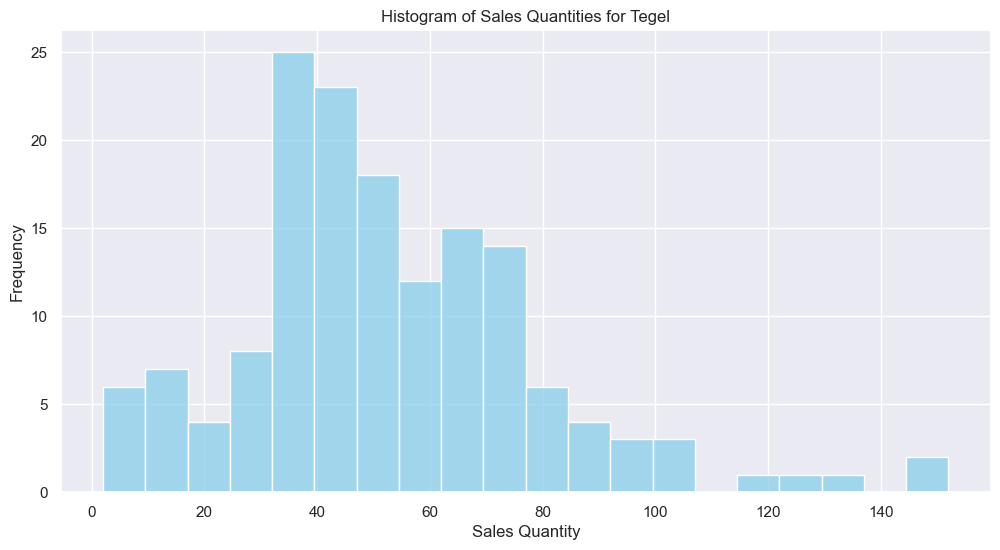

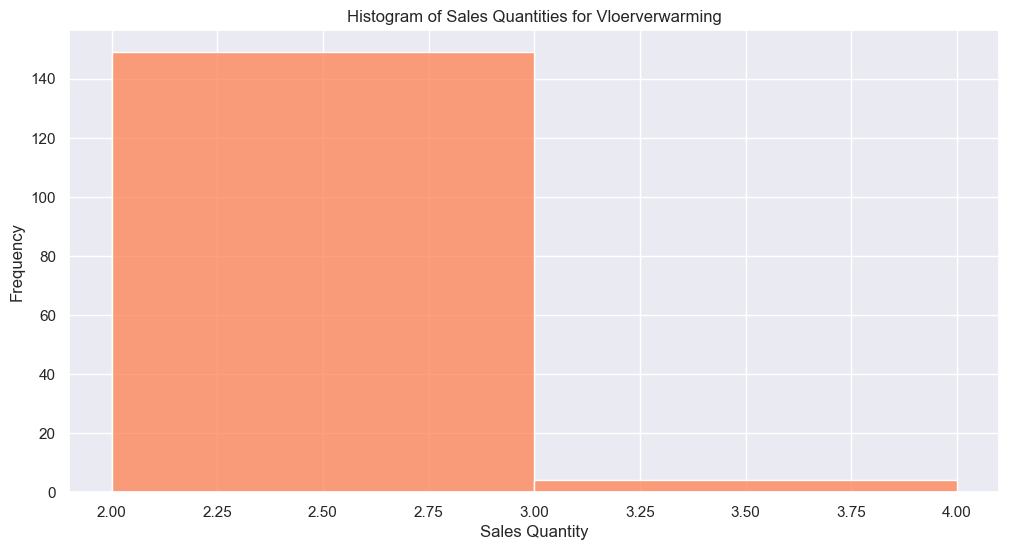

In [46]:
plt.figure(figsize=(12, 6))
sns.histplot(ex_data['Tegel'], kde=False, color='skyblue', bins=20)
plt.title('Histogram of Sales Quantities for Tegel')
plt.xlabel('Sales Quantity')
plt.ylabel('Frequency')
plt.show()

# Histogram for Vloerverwarming
plt.figure(figsize=(12, 6))
sns.histplot(ex_data['Vloerverwarming'], kde=False, color='coral', bins=2)
plt.title('Histogram of Sales Quantities for Vloerverwarming')
plt.xlabel('Sales Quantity')
plt.ylabel('Frequency')
plt.show()